# Школа Лингвистики
## НИУ ВШЭ, 2019-2020 учебный год

### Домашнее задание №6, использование VK.API

Задание выполнил(а): Дарья Матяш, БКЛ-181

## Обработка данных

Для начала импортируем нужные модули

In [1]:
import requests
import json
from tqdm.auto import tqdm
import numpy as np
import time  
from tqdm import tqdm 
from datetime import datetime

In [2]:
TOKEN = '78c487fc78c487fc78c487fc1c78b5e792778c478c487fc26678cc09ddf1f820d435765'
version = '5.103'

Выкачаем 1500 постов группы ГМИИ им. А.С. Пушкина в социальной сети "Вконтакте":

In [3]:
for i in tqdm(range(1500)):
    group = 'theartsmuseum'
    data = requests.get(
    'https://api.vk.com/method/wall.get', 
        params={
            "domain": group,
            "v":version,
            "access_token": TOKEN,
            "count": 1500
        }
    ).json()
    time.sleep(1 * 10 ** (-10))  #  чтобы не было ошибки

100%|██████████| 1500/1500 [17:53<00:00,  1.40it/s]


Запоминаем id постов, а также количество лайков, репостов и просмотров для каждого поста:

In [4]:
posts_id = []
likes = []
views = []
reposts = []
posts = []
time = []


for i in range(len(data['response']['items'])):
    if data['response']['items'][i]['text'] != '': 
        #делаем проверку на то, что пост все-таки 
        #с текстом - т.к. мы хотим все же поработать с тестовыми данными
        posts_id.append(data['response']['items'][i]['id'])
        likes.append(data['response']['items'][i]['likes']['count'])
        views.append(data['response']['items'][i]['views']['count'])
        reposts.append(data['response']['items'][i]['reposts']['count'])
        posts.append(data['response']['items'][i]['text'])
        unixtime = data['response']['items'][i]['date']  
        utc = str(datetime.fromtimestamp(unixtime))
        time.append(utc)  #  запишем время 
    

Теперь лемматизируем посты (исходные тексты также останутся):

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

sw = stopwords.words('russian')
token_texts = []
all_lemmas = []
for i in range(len(posts)):
    #токенизируем текст, убираем стоп-слова
    words = [w.lower() for w in word_tokenize(posts[i]) if w.isalpha() if w.lower() not in sw]
    #лемматизируем текст, создаем список всех лемматизированных постов
    lems = []
    for l in words:
        lems.append(morph.parse(l)[0].normal_form)
    all_lemmas.append(' '.join(lems))

Разнесем дату написания постов на три столбца: год, месяц и число появления поста в группе Пушкинского музея.

In [6]:
year = []
month = []
day = [] 

for q in range(len(time)):
    year.append(str(time[q][:4]))  #  год
    month.append(str(time[q][5:7]))  #  месяц
    day.append(str(time[q][8:10]))  #  день


Создадим датафрейм, состоящих из id поста, его текста, числа комментариев, репостов и лайков для каждого поста:

In [7]:
import pandas as pd

In [8]:
df1 = pd.DataFrame({
    'post_id': posts_id,
    'orig_texts': posts,
    'post_text': all_lemmas,
    'likes': likes, 
    'views': views, 
    'reposts': reposts,
    'years': year,
    'months': month,
    'days': day,
    })
df1.head(10)

,post_id,orig_texts,post_text,likes,views,reposts,years,months,days
0,12731,Сегодня Научная библиотека музея традиционно п...,сегодня научный библиотека музей традиционно п...,26,1488,3,2020,04,25
1,12730,Мы публикуем программу виртуальных экскурсий п...,публиковать программа виртуальный экскурсия по...,53,1982,15,2020,04,25
2,12724,"Вы когда-нибудь задумывались о том, сколько дл...",задумываться сколько длиться один минута казал...,27,2536,3,2020,04,24
3,12710,Смотрите в прямом эфире лекцию «Дагеротипия. Ч...,смотреть прямой эфир лекция дагеротипия видеть...,28,1865,8,2020,04,24
4,12701,Посмотрите онлайн-экскурсию по выставке «От Дю...,посмотреть выставка дюрер матисс избранный рис...,57,2841,12,2020,04,24
5,12699,Бульвар Сен-Мишель возник во время масштабной ...,бульвар возникнуть время масштабный перепланир...,29,2594,2,2020,04,23
6,12697,«Дагеротипия. Что видел фотограф в объективе ф...,дагеротипия видеть фотограф объектив фотокамера,33,2316,1,2020,04,23
7,12695,Посмотрите нашу онлайн-экскурсию «Вакханалия. ...,посмотреть наш вакханалия встреча два шедевр п...,46,2602,7,2020,04,23
8,12653,Друзья! Мы начинаем шестую встречу нашего онла...,друг начинать шесть встреча наш спросить храни...,63,2987,11,2020,04,23
9,12652,Друзья! В эту субботу в 18:00 филиал Пушкинско...,друг суббота филиал пушкинский музей гцсить ар...,12,1629,3,2020,04,23


## Сохранение данных

In [9]:
df1.to_csv('hw_06_01.csv')

## Визуализация данных

### __График 1:__ Зависимость количества репостов от количества лайков.
__Гипотеза:__ Чем больше людям пользователям нравится запись (чем больше лайков под постом), тем больше будет сделано репостов.

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

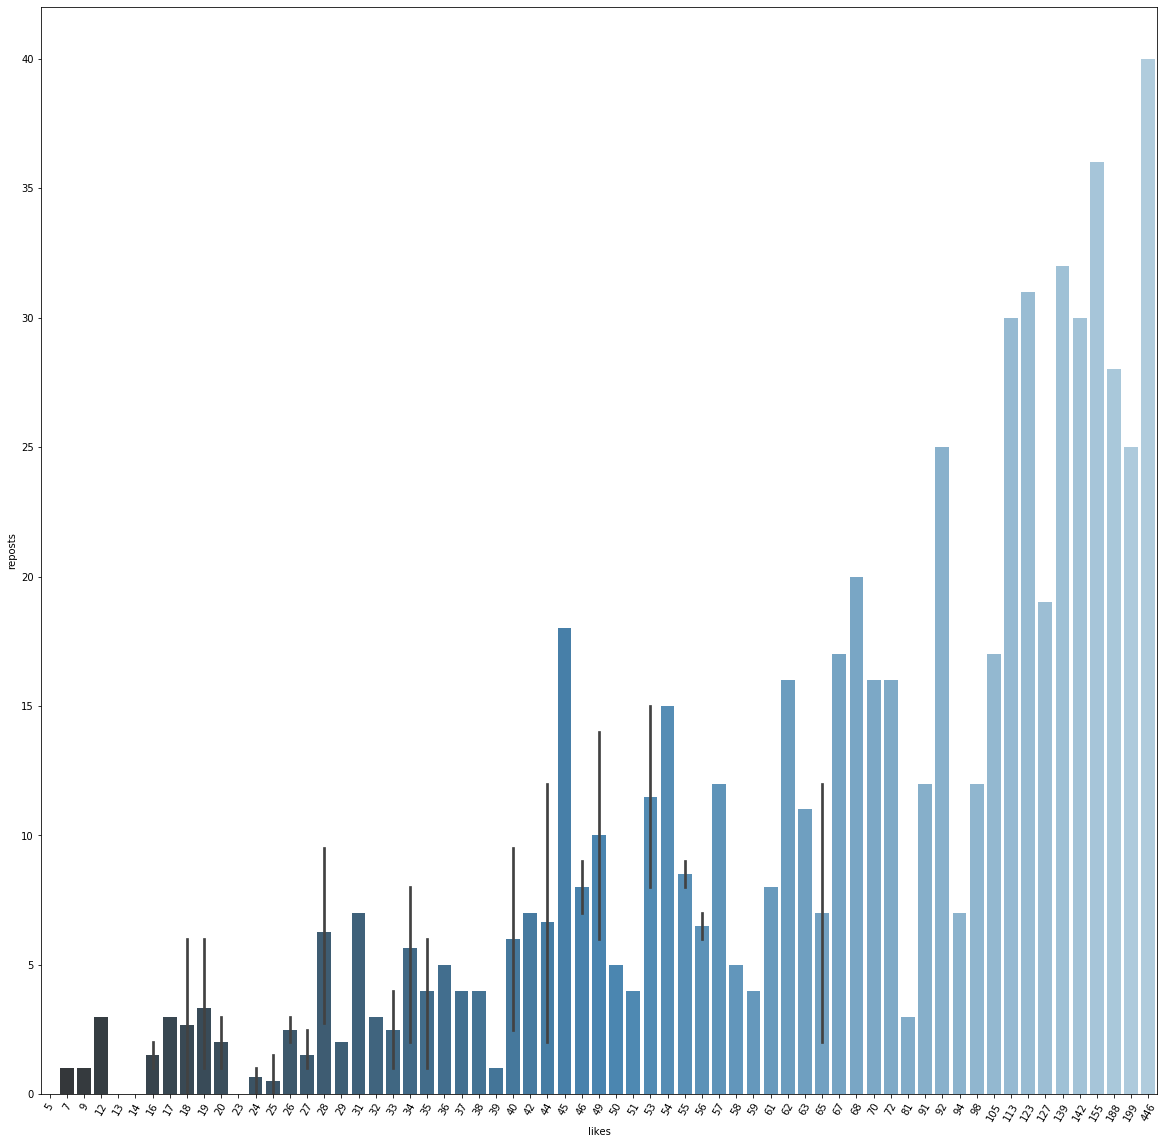

In [24]:
plt.figure(figsize=(20,20))
plt.xticks(rotation=60)
sns.barplot(x="likes", y="reposts", data=df1, palette="Blues_d") 


__Вывод:__ Получилось действительно так: чем больше у поста лайков, тем больше у него репостов.

### __График 2:__ Зависимость количества лайков от количества просмотров.
__Гипотеза:__ Чем больше людям пользователям нравится запись (чем больше лайков под постом), тем больше будет сделано репостов.

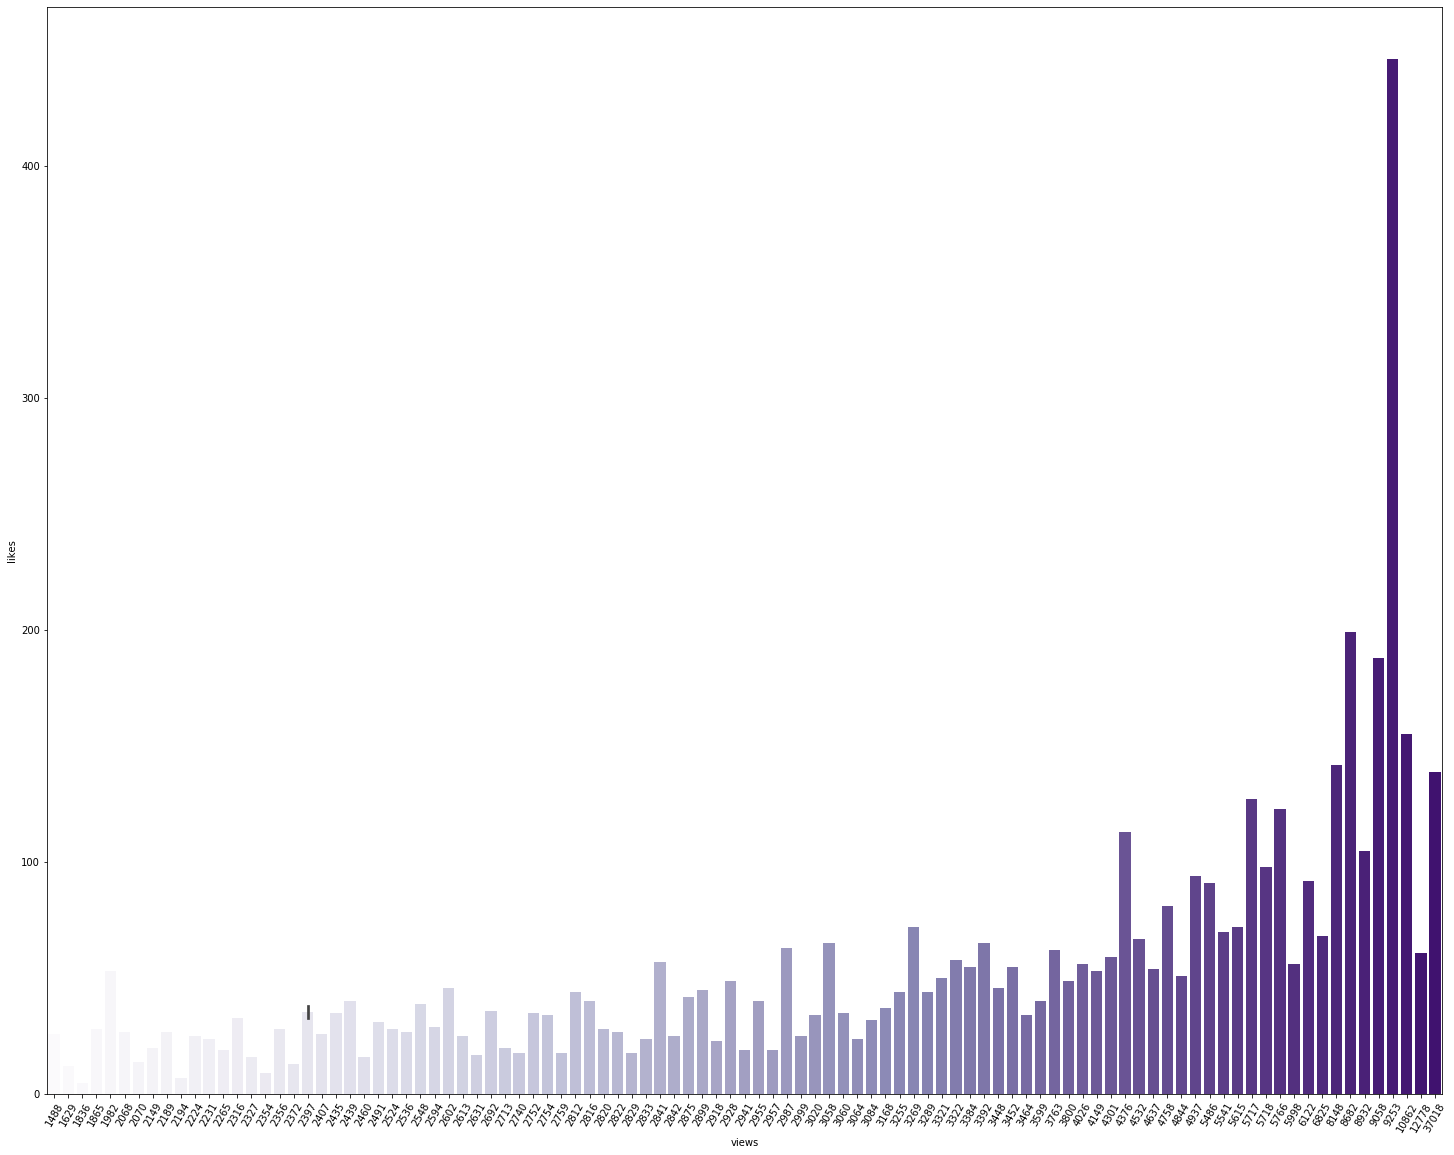

In [26]:
plt.figure(figsize=(25,20))
plt.xticks(rotation=60)
sns.barplot(x="views", y="likes", data=df1, palette="Purples")

__Вывод:__ Получилось не совсем так: действительно, чаще всего происходит так: чем больше просмотров, тем больше лайков, но периодически есть исключения, здесь также все зависит от степени "интересности" поста.

### __График 3:__ Распределение постов по месяцам.
__Гипотеза:__ Возможно, будет больше постов в месяце, в котором есть какой-нибудь праздник официальный или же музейный.

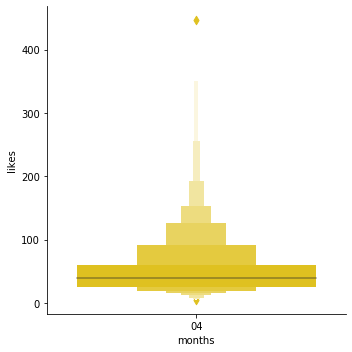

In [27]:
sns.catplot(x="months", y="likes", kind="boxen",
            data=df1.sort_values("months"), palette = "prism");

Здесь мы можем видеть, что все обкачанные посты были обубликованы в марте и большее число лайков под постами- около 50-70, но в то же время и есть посты, чьё число лайков составило более 400.

### __График 4:__ Облако слов.

In [71]:
from wordcloud import WordCloud

In [68]:
from collections import Counter
count_lem = Counter(' '.join(all_lemmas).split())
lem_top_100 = ' '.join(list(dict(count_lem.most_common(100)).keys()))

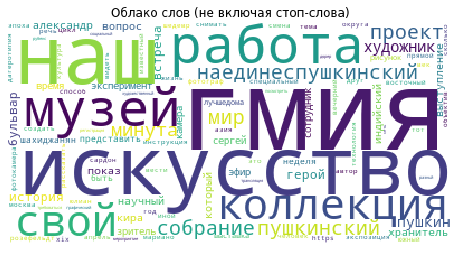

In [79]:
wordcloud = WordCloud( background_color ='white',).generate(lem_top_100)
# отобразим вордклауд

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов (не включая стоп-слова)')
plt.show()

Заметим странное слово "гмия" - это лемма слова "ГМИИ" - сокращение от "Государственного музея изобразительных искусств", к сожалению, неправильно определена начальная форма слова, т.к. все слова были приведены к нижнему регистру, соотвественно, и ГМИИ определеть как сокращение было невозможно. Однако несмотря на это, 